### Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

#### Preliminary Peer Assessment

It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:

- Preparation – were they prepared during team meetings?
- Contribution – did they contribute productively to the team discussion and work?
- Respect for others’ ideas – did they encourage others to contribute their ideas?
- Flexibility – were they flexible when disagreements occurred?

Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.

Preliminary Peer Assessment: [https://goo.gl/forms/WOYC7pwRCSU0yV3l1](https://goo.gl/forms/WOYC7pwRCSU0yV3l1)

In [119]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import StringIO
from PIL import Image
import urllib
from random import sample
from imdb import IMDb
import tmdbsimple as tmdb
from sklearn import svm
import time
from sklearn.datasets import make_multilabel_classification
from sklearn.cross_decomposition import CCA
tmdb.API_KEY = 'c5d41f08e55fca6e9f5fc0b6d1735540'

# Detailed description and implementation of two different models

We actually created three different models for this milestone. We started with a random forest and a svm to train as Multi-class classifier. But as we were working through the process, we had an hypothesis that the problem might actually make more sense as a multi label problem. Our third model was a Multi-label model with OneVSrest Randomforest classifier.
We went and explored through a few sets of different features (budgets, revenues, studio, and ect) and ultimately settled on using features extracted directly from the poster. We created 8 news features by extracting the top 5 dominant colors of each poster, and calculated the color intensity (by summing r,b,g values horizontally) and the average red, blue, and green scales (by averaging r,b,g values vertically). We figured that since the final deliverable will heavily involve the posters, we though we tried to use features from the posters for milestone 3, so we'll have a benchmark for later.

In [2]:
#read in genre and movie id multi class
mmc = pd.read_csv('C:\Users\Chad\Desktop\Data Science 2\Project\ms3\y_labels_multiclass2.csv')

#access pull infomration from api with smaller subset first 
#rowindex =  np.array(sample(xrange(len(mmc)), 2000))
#mmcr = mmc.ix[rowindex]
#mmcr = mmcr.reset_index(drop=True)


In [22]:
mmcr.head()

,movie_id,genre_id,genre_name
0,57119,35,Comedy
1,18607,35,Comedy
2,157845,53,Thriller
3,37786,10749,Romance
4,164558,99,Documentary


In [3]:
def getMovies(tmdb_id):
    movie = tmdb.Movies(tmdb_id)
    return movie.info()

In [4]:
#found a nice example of extracting dominate color palette from image, modify a bit for our project
#http://stackoverflow.com/a/16216866/190597 (Jaime)
#http://stackoverflow.com/a/16840350/190597 (Jaime)

def palette(img):
    arr = np.asarray(img)
    palette, index = np.unique(asvoid(arr).ravel(), return_inverse=True)
    palette = palette.view(arr.dtype).reshape(-1, arr.shape[-1])
    count = np.bincount(index)
    order = np.argsort(count)
    return palette[order[::-1]]

def asvoid(arr):
    arr = np.ascontiguousarray(arr)
    return arr.view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[-1])))


In [5]:
#generate a pallatte score for the top 5 dominate color in this image
#calculate color intensity for top 5 dominate color
#calcuate average red, blue, green scale
def getPaletteScore(mpath):
    base_url = "https://image.tmdb.org/t/p/"
    file_size = "w500"
    poster_path = mpath 
    poster_url = base_url+file_size+poster_path
    img = Image.open(urllib.urlopen(poster_url), 'r').convert('RGB')
    palettescore = np.sum(palette(img)[:5], axis = 1)
    avgRBG = np.mean(palette(img)[:5], axis = 0)
    return palettescore, avgRBG

In [82]:
idx = range(0, len(mmc))
cols = ['genre_name', 'movie_id', 'popularity', 'budget', 'revenue', 'pal_intensity_1', 'pal_intensity_2', 'pal_intensity_3', 
        'pal_intensity_4', 'pal_intensity_5', 'avg_red', 'avg_blue', 'avg_green']
df = pd.DataFrame(index=idx, columns=cols)

for i in range(0,len(mmc)):
    movie = getMovies(mmc.ix[i, 'movie_id'])
    pal_score, avgRBG = getPaletteScore(movie['poster_path'])
    df['genre_name'][i] = mmc.ix[i, 'genre_name']
    df['id'][i] = mmc.ix[i, 'movie_id']
    df['popularity'][i] = movie['popularity']
    df['budget'][i] = movie['budget']
    df['revenue'][i] = movie['revenue']
    df['pal_intensity_1'][i] = pal_score[0]
    df['pal_intensity_2'][i] = pal_score[1]
    df['pal_intensity_3'][i] = pal_score[2]
    df['pal_intensity_4'][i] = pal_score[3]
    df['pal_intensity_5'][i] = pal_score[4]
    df['avg_red'][i] = avgRBG[0]
    df['avg_blue'][i] = avgRBG[1]
    df['avg_green'][i] = avgRBG[2]

In [27]:
#save to csv
#df.to_csv('C:\Users\Chad\Desktop\Data Science 2\Project\ms3\movie_df.csv', sep=',')
df = pd.read_csv('C:\Users\Chad\Desktop\Data Science 2\Project\ms3\movie_df.csv', sep=',')

In [28]:
def split(data):
    length = data.shape[0]
    indices = range(length)
    np.random.shuffle(indices)
    train_indices = indices[0:int(length * .7)]
    test_indices = indices[int(length * .7):]
    train = data.iloc[train_indices]
    test = data.iloc[test_indices]
    return train, test


In [40]:
train, test = split(df)
y_train = train.iloc[:, 0]
x_train = train.iloc[:, 5:]
y_test = test.iloc[:, 0]
x_test = test.iloc[:, 5:]

#scale the features
x_train = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x_train.values))
x_test = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x_test.values))

# Description of your performance metrics 

For the two Multi-class models, we use the built in model.score as validation score for training, and use confusionmatrix along with test accuracy and recall for the test performance metric.
For the Multi-Label model, we use F1 as the validation score for training, and use confusionmatrix along with F1 score and hamming loss as test performance metric. 

In [43]:
n_trees = np.arange(1, 151, 5)  
depths = np.arange(1, 25)   

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '3-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds = KFold(train.shape[0], n_folds=3, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train.iloc[train_indices]
            y_train_cv = y_train.iloc[train_indices]
            # Generate validation data
            x_validate = x_train.iloc[validation_indices]
            y_validate = y_train.iloc[validation_indices]
            
            # Fit random forest on training data
            model = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth, class_weight = 'balanced')
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        average_score = np.mean(scores)
        #print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth

# Fit model on entire train set using chosen number of trees and depth
model = ensemble.RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_train, y_train)

print 'Chosen number of trees, depth:', best_trees, ',', best_depth
print 'Test accuracy:', model.score(x_test, y_test)

3-fold cross validation:
Chosen number of trees, depth: 111 , 10
Test accuracy: 0.323492723493


In [44]:
preds = model.predict(x_test)
pd.crosstab(y_test, preds, rownames=['actual'], colnames=['preds'])

preds,Action,Animation,Comedy,Drama,Romance,Thriller
actual,,,,,,
Action,271,5,107,5,6,117
Animation,43,16,89,3,6,10
Comedy,130,15,363,8,27,45
Documentary,28,7,57,1,2,16
Drama,74,6,112,3,7,32
Romance,95,6,222,3,18,26
Thriller,222,4,83,2,6,107


In [47]:
#fitting with svm
Cost = np.arange(.1, 2, .1)  
gamma = np.arange(.05, .5, .05)   

# To keep track of the best model
svmr_best_score = 0

# Run grid search for model with 5-fold cross validation
print '3-fold cross validation:'

for c in Cost:
    for g in gamma:
        
        # Cross validation for every experiment
        k_folds = KFold(train.shape[0], n_folds=3, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train.iloc[train_indices]
            y_train_cv = y_train.iloc[train_indices]
            # Generate validation data
            x_validate = x_train.iloc[validation_indices]
            y_validate = y_train.iloc[validation_indices]
            
            # Fit random forest on training data
            svmr_model = svm.SVC(C=c, gamma=g, kernel = 'rbf', class_weight = 'balanced')
            svmr_model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores = [svmr_model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        current_score = scores
        #print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if current_score > svmr_best_score:
            svmr_best_score = current_score
            best_cost = c
            best_gamma = g


svmr_model = svm.SVC(C = best_cost, gamma = best_gamma, kernel = 'rbf', class_weight = 'balanced')
svmr_model.fit(x_train, y_train)

print 'Chosen Cost, gamma:', best_cost, ',', best_gamma
print 'Test accuracy:', svmr_model.score(x_test, y_test)

3-fold cross validation:
Chosen Cost, gamma: 1.9 , 0.15
Test accuracy: 0.264449064449


In [48]:
svmr_preds = svmr_model.predict(x_test)
pd.crosstab(y_test, svmr_preds, rownames=['actual'], colnames=['preds'])

preds,Action,Animation,Comedy,Documentary,Drama,Romance,Thriller
actual,,,,,,,
Action,17,16,63,51,16,13,335
Animation,1,36,54,17,1,11,47
Comedy,10,72,259,58,15,35,139
Documentary,3,17,37,9,3,4,38
Drama,4,19,78,31,7,6,89
Romance,6,28,175,31,11,16,103
Thriller,13,19,58,29,6,7,292


# Careful performance evaluations for both models and Performance

There are two models fitted as Multi-class classifier and one model fitted as Multi-label classifier.  The two Multi-class has an test accuracy of 32% and 26%.  This is on the low side and is proving the models (and its features) to be quite ineffecitve in predicting the genres of the movies.  When looking at the confusion matrix, the first Multi-class model (random forest) actually seems to do a decent job in predicting "comedy" and "action".  However, it tends to get "romance" mixed up with "comedy" and "action" mixed up with "thriller".  The second Multi-class model (SVM with radial kernel) actually did worst than the random forest. (we think SVM with linear kernel might be better)  

We think the reason why the Multi Class model did so poorly is mainly because the movies can be group into multiple genres.  Thinking about this from a non-data science perspective actually made sense to us, most movies nowadays can be label by more than one single genre, for example "Actions" are often times paired up with "Comedy", "Romance" with "Drama", and etc.  Think "Ride Along 2", "Rush Hours", and etc.  

The 3rd model, the Multi-label model achieve an accuray of 66% with F1 score, this is significantly better than the first two multi class model.  The result is inline with our expectation on multi genre. 

In [52]:
#Multi Label Model 

mml = pd.read_csv('C:\Users\Chad\Desktop\Data Science 2\Project\ms3\mml.csv')
mml2 = mml.merge(df, on='movie_id', how='left')

In [53]:
mml_train, mml_test = split(mml2)

In [58]:
y_mml_train = mml_train['genre_name_x']
x_mml_train = mml_train.iloc[:,6:]
y_mml_test = mml_test['genre_name_x']
x_mml_test = mml_test.iloc[:,6:]
Y_mml_train = MultiLabelBinarizer().fit_transform(y_mml_train)
Y_mml_test = MultiLabelBinarizer().fit_transform(y_mml_test)


In [ ]:
n_trees = np.arange(1, 151, 5)  
depths = np.arange(1, 25)   

# To keep track of the best model
best_score_mml = 0

# Run grid search for model with 5-fold cross validation
print '3-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds_mml = KFold(x_mml_train.shape[0], n_folds=3, shuffle=True)
        scores_mml = []
        for train_indices, validation_indices in k_folds_mml:
            # Generate training data
            x_train_cv_mml = x_mml_train.iloc[train_indices]
            y_train_cv_mml = Y_mml_train[train_indices]
            # Generate validation data
            x_validate_mml = x_mml_train.iloc[validation_indices]
            y_validate_mml = Y_mml_train[validation_indices]
            
            # Fit random forest on training data
            model_mml = OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth))
            model_mml.fit(x_train_cv_mml, y_train_cv_mml)
            # Score on validation data
            y_pred_cv_mml = model_mml.predict(x_validate_mml)
            scores_mml.append(f1_score(y_validate_mml, y_pred_cv_mml, average='samples'))
        
        # Record and report accuracy
        average_score_mml = np.mean(scores_mml)
        #print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score_mml > best_score_mml:
            best_score_mml = average_score_mml
            best_trees_mml = trees
            best_depth_mml = depth

In [75]:

# Fit model on entire train set using chosen number of trees and depth
model_mml = OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth))
model_mml.fit(x_mml_train, Y_mml_train)


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=111, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [126]:
print 'Chosen number of trees, depth:', best_trees_mml, ',', best_depth_mml
print 'Test F1 Score:', f1_score(Y_mml_test, model_mml.predict(x_mml_test), average='samples')
print 'Hamming Loss:', hamming_loss(Y_mml_test, model_mml.predict(x_mml_test))

Chosen number of trees, depth: 66 , 4
Test F1 Score: 0.658603849428
Hamming Loss: 0.302447552448


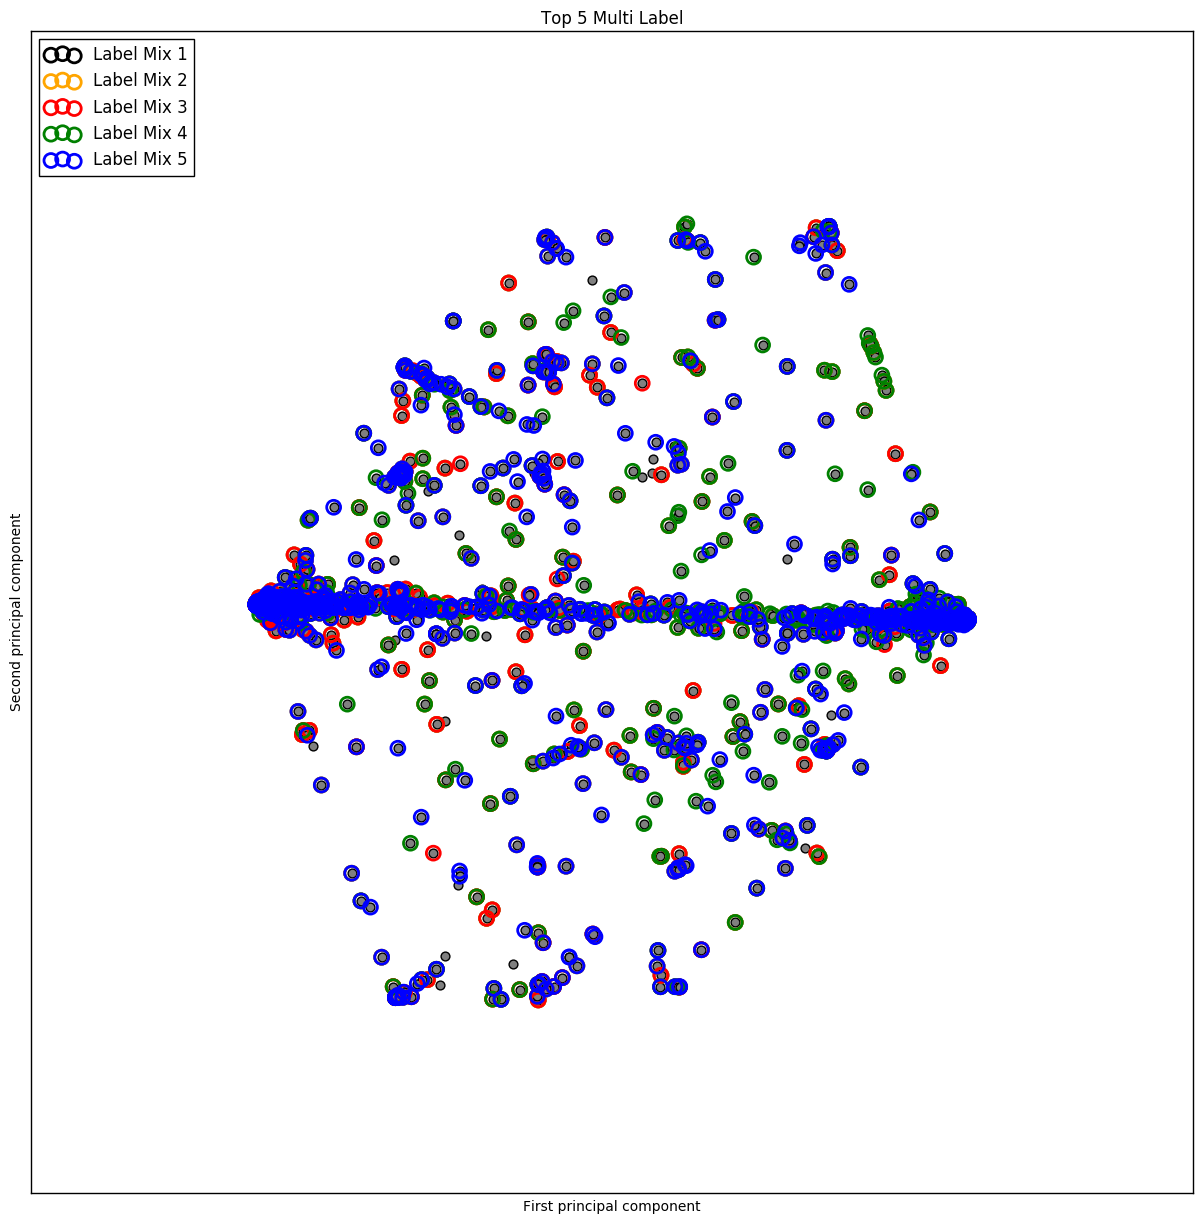

In [114]:

def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    model_mml = OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators=66, max_depth=4))
    model_mml.fit(X, Y)

    plt.subplot(1, 1, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    four_class = np.where(Y[:, 4])
    five_class = np.where(Y[:, 5])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=100, edgecolors='black',
               facecolors='none', linewidths=2, label='Label Mix 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=100, edgecolors='orange',
               facecolors='none', linewidths=2, label='Label Mix 2')
    plt.scatter(X[two_class, 0], X[two_class, 1], s=100, edgecolors='red',
               facecolors='none', linewidths=2, label='Label Mix 3')
    plt.scatter(X[three_class, 0], X[three_class, 1], s=100, edgecolors='green',
               facecolors='none', linewidths=2, label='Label Mix 4')
    plt.scatter(X[four_class, 0], X[four_class, 1], s=100, edgecolors='blue',
               facecolors='none', linewidths=2, label='Label Mix 5')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper left")


plt.figure(figsize=(15,15))


plot_subfigure(x_mml_test, Y_mml_test, 1, 'Top 5 Multi Label', 'pca')
plt.show()

# Discussion of the differences between the models, strengths, weaknesses
The Multi-class did not do as well in fitting and predicting genres because most of the movies tends to fall into multiple genres, this effectively made the problem more of a multi label one rather than multi class.  However, there are some strengths of using a multi class model.  One of the strength are the simplicity in understanding the output of the genres a confusion matrix.  Another strength is the running time being much quicker than the multi label model. 

The weakness of the multi label model is its running time, and the complexity in convert the Y binary array back into meaning Labels.  But the strength in this case, are the superior accuracy.

